In [77]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


**In this notebook we predict medical cost using linear and polynomial regression with Pyspark.**

In [78]:
#this code sets a filter to ignore warning messages
import warnings
warnings.filterwarnings("ignore")

# Installing Pyspark

In [79]:
!pip install pyspark

# Initializing a SparkSession object

In [80]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.master("local[*]").getOrCreate()
spark

# Importing the necessary packages

In [81]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import *
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.feature import PolynomialExpansion

# Loading the insurance data

In the next two cells, we will first load the dataset and then write some code to find out the shape of our dataset.

In [82]:
#loading data
insurance_df=spark.read.load('/kaggle/input/insurance/insurance.csv',
                     format="csv",header="true",inferschema="true")
insurance_df.show(10)

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
+---+------+------+--------+------+---------+-----------+
only showing top 10 rows



In [83]:
#shape of the data
num_rows =insurance_df.count()
num_cols = len(insurance_df.columns)
print("num rows: {}   ,   num cols: {}".format(num_rows,num_cols))

num rows: 1338   ,   num cols: 7


This data contains 7 columns. We use the features like age, sex, bmi, number of children, smoker or non-smoker, and region to predict the cost of insurance.

# Preprocessing

First, we want to gain some information about our data. After running this code, we can find out the data type of each column.

In [84]:
insurance_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



This code is performing some basic data cleaning operations like removing all the Null values and Duplicates and then we count the number of rows of the data.

In [85]:
#droping Null values and duplicates
insurance_df=insurance_df.dropna()
insurance_df=insurance_df.dropDuplicates()
insurance_df.count()

1337

After removing the null and duplicate values, we see that the number of rows has reduced by one.

In this cell we convert our string columns 'region', 'sex', and 'smoker' to integers.

In [86]:
#string to int for region column
mapping = {"northeast": 0, "northwest": 1, "southeast": 2, "southwest": 3}
insurance_df = insurance_df.withColumn("region_int", when(insurance_df.region == "northeast", mapping["northeast"])
                   .when(insurance_df.region == "northwest", mapping["northwest"])
                   .when(insurance_df.region == "southeast", mapping["southeast"])
                   .otherwise(mapping["southwest"]))
insurance_df=insurance_df.drop("region")

#string to int for sex column
insurance_df = insurance_df.withColumn("sex_int", when(insurance_df.sex == "female", 1).otherwise(0))
insurance_df=insurance_df.drop("sex")

#string to int for smoker column
insurance_df = insurance_df.withColumn("smoker_int", when(insurance_df.smoker == "yes", 1).otherwise(0))
insurance_df=insurance_df.drop("smoker")

insurance_df.show(10)

+---+------+--------+-----------+----------+-------+----------+
|age|   bmi|children|    charges|region_int|sex_int|smoker_int|
+---+------+--------+-----------+----------+-------+----------+
| 60|  39.9|       0|  48173.361|         3|      0|         1|
| 40|26.315|       1| 6389.37785|         1|      0|         0|
| 54|  30.8|       3|   12105.32|         3|      1|         0|
| 46|  22.3|       0|   7147.105|         3|      0|         0|
| 18| 17.29|       2| 12829.4551|         0|      0|         1|
| 45|  30.2|       1|   7441.053|         3|      0|         0|
| 29| 29.64|       1|20277.80751|         0|      0|         0|
| 34| 25.27|       1|  4894.7533|         1|      0|         0|
| 18|29.165|       0|7323.734819|         0|      1|         0|
| 61| 25.08|       0|24513.09126|         2|      1|         0|
+---+------+--------+-----------+----------+-------+----------+
only showing top 10 rows



# Correlation Matrix

In this cell we calculate the correlation matrix for the numerical columns in our DataFrame using the "corr" function from the "stat" module of PySpark.

In [87]:
#Calculating the correlation matrix
columns= insurance_df.columns
correlation_matrix= np.zeros((len(columns),len(columns)))
for i in range(len(columns)):
      for j in range(len(columns)):
            correlation_matrix[i][j]=insurance_df.stat.corr(columns[i],columns[j])

<Axes: >

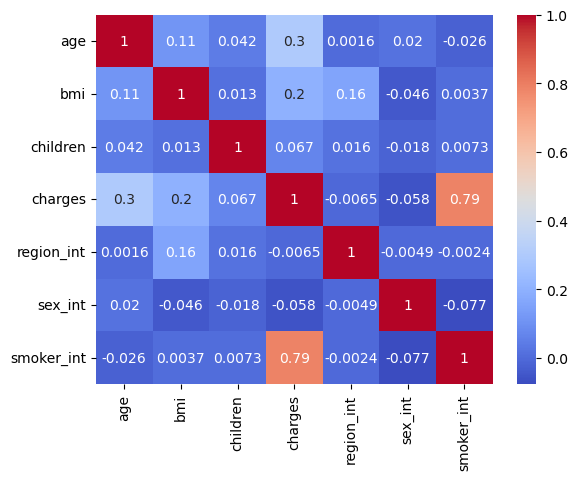

In [88]:
sns.heatmap(correlation_matrix,annot=True, cmap='coolwarm',xticklabels=columns,yticklabels=columns)

# Univariate Analysis

In the following four cells, we generate bar plots to visualize the frequency counts for several columns in the DataFrame. Specifically, we plot the frequency counts for the 'smoker_int', 'children', 'sex_int', and 'region_int' columns

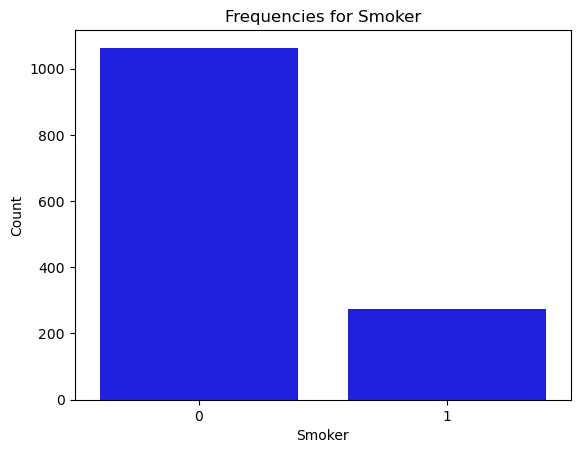

In [89]:
pandas_df = insurance_df.toPandas()
sns.countplot(data=pandas_df, x='smoker_int',color='blue')
plt.title("Frequencies for Smoker", fontsize=12)
plt.xlabel("Smoker")
plt.ylabel("Count")
plt.show()

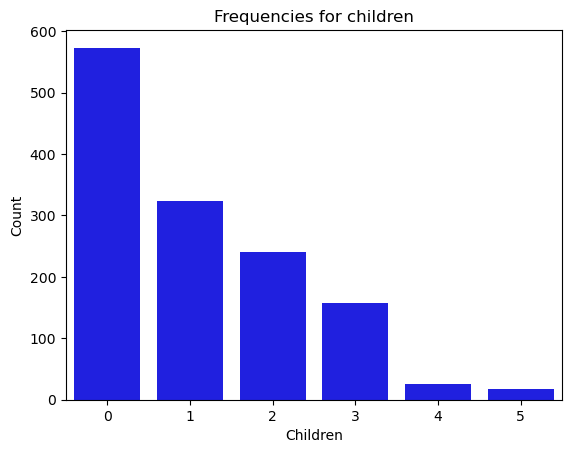

In [90]:
sns.countplot(data=pandas_df, x='children',color='blue')
plt.title("Frequencies for children", fontsize=12)
plt.xlabel("Children")
plt.ylabel("Count")
plt.show()

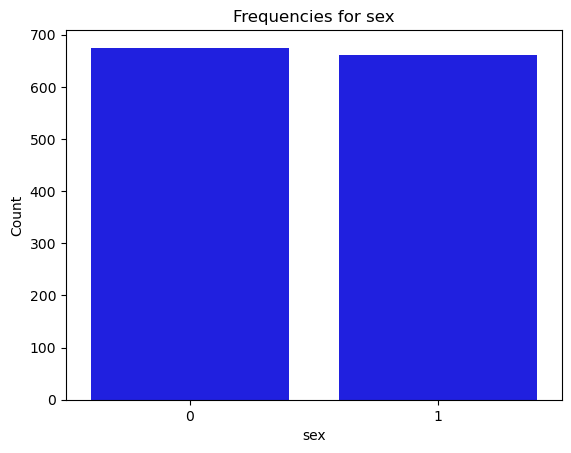

In [91]:
sns.countplot(data=pandas_df, x='sex_int',color='blue')
plt.title("Frequencies for sex", fontsize=12)
plt.xlabel("sex")
plt.ylabel("Count")
plt.show()

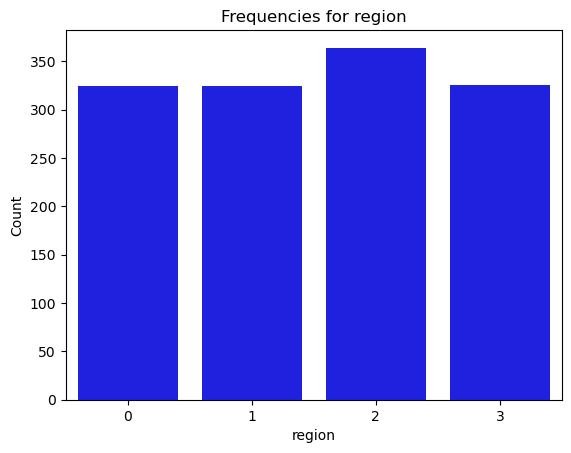

In [92]:
sns.countplot(data=pandas_df, x='region_int',color='blue')
plt.title("Frequencies for region", fontsize=12)
plt.xlabel("region")
plt.ylabel("Count")
plt.show()

In the following two cells, we generate density plots to visualize the distribution of values in the 'age' and 'bmi' columns.

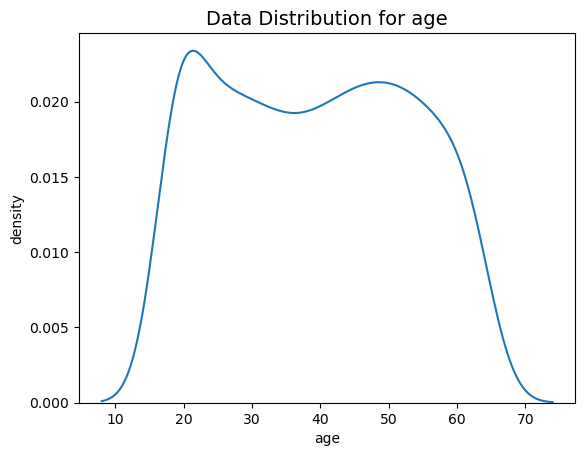

In [93]:
sns.distplot(pandas_df["age"], hist=False)
plt.title("Data Distribution for age", fontsize=14)
plt.xlabel("age")
plt.ylabel("density")
plt.show()

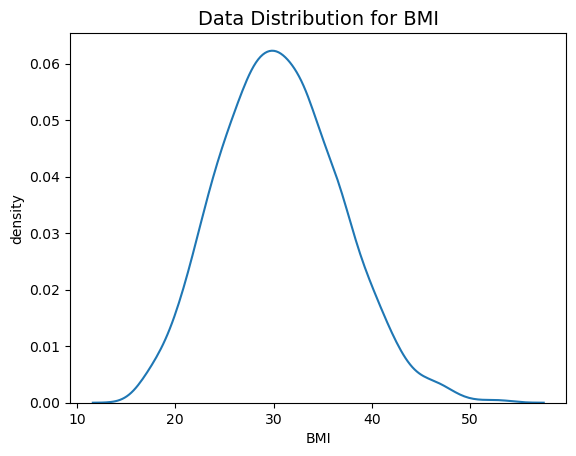

In [94]:
sns.distplot(pandas_df["bmi"], hist=False)
plt.title("Data Distribution for BMI", fontsize=14)
plt.xlabel("BMI")
plt.ylabel("density")
plt.show()

# Simple Linear Regression

Here, we establish two simple linear regression models. The first model includes all of the features, while the second model removes the features that have a low correlation with the target variable.

**First model: with all of the features**

In [95]:
vectorassembler1=VectorAssembler(inputCols= ["age","bmi","children","region_int","sex_int","smoker_int"],
                                outputCol="feature_vector")

insurance_vector1=vectorassembler1.transform(insurance_df)
insurance_vector1=insurance_vector1.select(["feature_vector","charges"])

insurance_vector.show()

+--------------------+-----------+
|      feature_vector|    charges|
+--------------------+-----------+
|[60.0,39.9,0.0,3....|  48173.361|
|[40.0,26.315,1.0,...| 6389.37785|
|[54.0,30.8,3.0,3....|   12105.32|
|[46.0,22.3,0.0,3....|   7147.105|
|[18.0,17.29,2.0,0...| 12829.4551|
|[45.0,30.2,1.0,3....|   7441.053|
|[29.0,29.64,1.0,0...|20277.80751|
|[34.0,25.27,1.0,1...|  4894.7533|
|[18.0,29.165,0.0,...|7323.734819|
|[61.0,25.08,0.0,2...|24513.09126|
|(6,[0,1],[21.0,26...|  2102.2647|
|[52.0,18.335,0.0,...| 9991.03765|
|[62.0,32.68,0.0,1...| 13844.7972|
|[39.0,26.315,2.0,...| 7201.70085|
|[48.0,40.565,2.0,...|45702.02235|
|(6,[0,1],[61.0,33...|13143.86485|
|[33.0,39.82,1.0,2...|  4795.6568|
|[32.0,29.735,0.0,...| 4357.04365|
|[61.0,29.07,0.0,1...| 29141.3603|
|[49.0,27.17,0.0,2...|  8601.3293|
+--------------------+-----------+
only showing top 20 rows



In [96]:
#training the model
train_set1,test_set1=insurance_vector1.randomSplit([0.8,0.2])

#training the model
model1=LinearRegression(labelCol="charges", featuresCol="feature_vector")
model_trained1=model1.fit(train_set1)

#predicting
model_predict1=model_trained1.transform(test_set1)
model_predict1.show()

23/07/23 16:32:02 WARN Instrumentation: [27b8a2f1] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+-----------+-------------------+
|      feature_vector|    charges|         prediction|
+--------------------+-----------+-------------------+
|(6,[0,1],[18.0,21...|  1702.4553|-130.67727530520824|
|(6,[0,1],[18.0,25...|  1708.0014| 1154.1904641604906|
|(6,[0,1],[22.0,31...|  2254.7967|  4181.302706104703|
|(6,[0,1],[30.0,25...|  3645.0894|  4178.293561083401|
|(6,[0,1],[34.0,21...| 4500.33925| 3870.8680982237765|
|(6,[0,1],[61.0,23...|13129.60345| 11409.310203137864|
|(6,[0,1],[63.0,36...|13981.85035| 16135.035672774216|
|[18.0,17.29,2.0,0...| 12829.4551|  23081.23941407697|
|[18.0,21.78,2.0,2...|11884.04858| 298.05768918809554|
|[18.0,23.32,1.0,2...|  1711.0268| 324.22382176772044|
|[18.0,26.18,2.0,2...|  2304.0022|  1714.954444488616|
|[18.0,29.37,1.0,2...|  1719.4363|  2272.456860305936|
|[18.0,31.13,0.0,2...|  1621.8827| 2562.7923138290207|
|[18.0,31.68,2.0,2...| 34303.1672|  27104.54853198082|
|[18.0,31.73,0.0,0...| 33732.6867| 26791.741483830287|
|[18.0,33.

In [97]:
#calculating errors for Linear Regression
metric_name=["mae","r2"]
for metric in metric_name:
  evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="charges", metricName=metric)
  metric_value=evaluator.evaluate(model_predict1)
  print("{}: {}".format(metric,metric_value))

mae: 4192.699243811717
r2: 0.7520765009377104


**Second model: removing some of the features**

Here, we remove the features that have low correlation with the target value in the hope that our model will improve. Specifically, we remove features such as number of children, sex, and region that have very low correlation with our target variable.

In [98]:
vectorassembler2=VectorAssembler(inputCols= ["age","bmi","smoker_int"],
                                outputCol="feature_vector2")

insurance_vector2=vectorassembler2.transform(insurance_df)
insurance_vector2=insurance_vector2.select(["feature_vector2","charges"])
insurance_vector2.show()

+-----------------+-----------+
|  feature_vector2|    charges|
+-----------------+-----------+
|  [60.0,39.9,1.0]|  48173.361|
|[40.0,26.315,0.0]| 6389.37785|
|  [54.0,30.8,0.0]|   12105.32|
|  [46.0,22.3,0.0]|   7147.105|
| [18.0,17.29,1.0]| 12829.4551|
|  [45.0,30.2,0.0]|   7441.053|
| [29.0,29.64,0.0]|20277.80751|
| [34.0,25.27,0.0]|  4894.7533|
|[18.0,29.165,0.0]|7323.734819|
| [61.0,25.08,0.0]|24513.09126|
| [21.0,26.03,0.0]|  2102.2647|
|[52.0,18.335,0.0]| 9991.03765|
| [62.0,32.68,0.0]| 13844.7972|
|[39.0,26.315,0.0]| 7201.70085|
|[48.0,40.565,1.0]|45702.02235|
|[61.0,33.915,0.0]|13143.86485|
| [33.0,39.82,0.0]|  4795.6568|
|[32.0,29.735,0.0]| 4357.04365|
| [61.0,29.07,1.0]| 29141.3603|
| [49.0,27.17,0.0]|  8601.3293|
+-----------------+-----------+
only showing top 20 rows



In [99]:
#splitting into train and test
train_set2,test_set2=insurance_vector2.randomSplit([0.8,0.2])

#training the model
model2=LinearRegression(labelCol="charges", featuresCol="feature_vector2")
model_trained2=model2.fit(train_set2)

#predicting
model_predict2=model_trained2.transform(test_set2)
model_predict2.show()

23/07/23 16:32:04 WARN Instrumentation: [46cf7f21] regParam is zero, which might cause numerical instability and overfitting.


+-----------------+-----------+-------------------+
|  feature_vector2|    charges|         prediction|
+-----------------+-----------+-------------------+
| [18.0,20.79,0.0]|  1607.5101|-478.72211485517073|
|[18.0,21.565,1.0]|13747.87235| 23281.447369900052|
| [18.0,22.99,0.0]|  1704.5681| 255.63164080618117|
| [18.0,23.32,0.0]|  1711.0268|  365.7847041553832|
|[18.0,26.125,0.0]| 1708.92575|  1302.085742623607|
| [18.0,26.73,0.0]|  1615.7667|  1504.033025430479|
|  [18.0,28.5,0.0]|   1712.227|  2094.854001576201|
| [18.0,30.03,0.0]|  1720.3537|  2605.563658922505|
|  [18.0,30.4,0.0]|   3481.868| 2729.0686087382765|
| [18.0,39.14,0.0]|12890.05765|  5646.455801683827|
| [18.0,40.26,0.0]|  1634.5734|  6020.308622747787|
| [18.0,40.28,0.0]|  2217.6012|  6026.984565981074|
| [18.0,43.01,0.0]|  1149.3959|  6938.250817324475|
|  [19.0,18.6,0.0]|   1728.897| -947.7487453429658|
|  [19.0,19.8,0.0]|   1241.565| -547.1921513458656|
|  [19.0,20.3,0.0]|    1242.26|-380.29357051374063|
|  [19.0,20.

In [100]:
#calculating errors for Linear Regression with feature engineering
for metric in metric_name:
  evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="charges", metricName=metric)
  metric_value=evaluator.evaluate(model_predict2)
  print("{}: {}".format(metric,metric_value))

mae: 4145.590750171685
r2: 0.7666296949808932


# Polynomial regression

In the next three cells, we use polynomial regression of degree 2 to predict insurance cost, and then we evaluate the error metrics of the model.

In [101]:
degree = 2  # Degree of the polynomial
vectorassembler3 = VectorAssembler(inputCols= ["age","bmi","smoker_int"],
                                outputCol="feature_vector3")
insurance_vector3=vectorassembler3.transform(insurance_df)
poly_expansion = PolynomialExpansion(degree=degree, inputCol="feature_vector3", outputCol="poly_features")
df_poly = poly_expansion.transform(insurance_vector3)
df_poly=df_poly.select(["poly_features","charges"])

df_poly.show()

+--------------------+-----------+
|       poly_features|    charges|
+--------------------+-----------+
|[60.0,3600.0,39.9...|  48173.361|
|[40.0,1600.0,26.3...| 6389.37785|
|[54.0,2916.0,30.8...|   12105.32|
|[46.0,2116.0,22.3...|   7147.105|
|[18.0,324.0,17.29...| 12829.4551|
|[45.0,2025.0,30.2...|   7441.053|
|[29.0,841.0,29.64...|20277.80751|
|[34.0,1156.0,25.2...|  4894.7533|
|[18.0,324.0,29.16...|7323.734819|
|[61.0,3721.0,25.0...|24513.09126|
|[21.0,441.0,26.03...|  2102.2647|
|[52.0,2704.0,18.3...| 9991.03765|
|[62.0,3844.0,32.6...| 13844.7972|
|[39.0,1521.0,26.3...| 7201.70085|
|[48.0,2304.0,40.5...|45702.02235|
|[61.0,3721.0,33.9...|13143.86485|
|[33.0,1089.0,39.8...|  4795.6568|
|[32.0,1024.0,29.7...| 4357.04365|
|[61.0,3721.0,29.0...| 29141.3603|
|[49.0,2401.0,27.1...|  8601.3293|
+--------------------+-----------+
only showing top 20 rows



In [102]:
#splitting into train and test
train_set3,test_set3=df_poly.randomSplit([0.8,0.2])

#training the model
model3=LinearRegression(labelCol="charges", featuresCol="poly_features")
model_trained3=model3.fit(train_set3)

#predicting
model_predict3=model_trained3.transform(test_set3)
model_predict3.show()

23/07/23 16:32:06 WARN Instrumentation: [00b5b820] regParam is zero, which might cause numerical instability and overfitting.
23/07/23 16:32:06 WARN Instrumentation: [00b5b820] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


+--------------------+-----------+------------------+
|       poly_features|    charges|        prediction|
+--------------------+-----------+------------------+
|[18.0,324.0,17.29...| 12829.4551| 6799.649325269739|
|[18.0,324.0,23.08...| 1704.70015| 3313.420225785828|
|[18.0,324.0,25.46...|  1708.0014|3574.2558731491254|
|[18.0,324.0,26.12...| 1708.92575| 3629.633945357152|
|[18.0,324.0,26.31...| 2198.18985| 3644.037473296202|
|[18.0,324.0,28.21...| 2200.83085|3753.3915027597895|
|[18.0,324.0,31.13...|  1621.8827| 3798.580758557363|
|[18.0,324.0,33.15...| 2207.69745| 3742.606070896166|
|[18.0,324.0,33.33...|  1135.9407| 3734.406304155541|
|[18.0,324.0,34.43...|  1137.4697| 3670.615995303994|
|[18.0,324.0,35.62...| 2211.13075|3577.3643212103407|
|[18.0,324.0,36.85...| 36149.4835|36854.131369074814|
|[18.0,324.0,38.17...|  1631.6683|3295.6362447109086|
|[18.0,324.0,38.28...|14133.03775|3280.9087356577556|
|[18.0,324.0,38.66...| 3393.35635| 3227.698042185054|
|[18.0,324.0,39.14...|12890.

In [103]:
#calculating errors for polynomial regression
for metric in metric_name:
  evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="charges", metricName=metric)
  metric_value=evaluator.evaluate(model_predict3)
  print("{}: {}".format(metric,metric_value))

mae: 2878.8794271085376
r2: 0.8513800847560815


The error metrics used for all three models are MAE and R-squared. While the polynomial regression model is performing better than the previous two models, the difference between the two linear models is not significant. Therefore, further investigation is needed to determine which of the linear models works better.